In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt



In [3]:
data = np.loadtxt('MNIST/mnist_train.csv', delimiter=',',)

In [52]:
labels = data[:,0]
images = data[:,1:]>0

In [74]:
# distances from center in an 28x28 image
x = np.linspace(-13.5, 13.5, 28)


dists = np.sqrt(np.add.outer(x**2, x**2))

In [ ]:
from torch_geometric.nn import GCNConv, Linear, GraphConv
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from typing import Union, Tuple
from torch_geometric.typing import Adj, OptTensor, Size, OptPairTensor, Tensor
from torch_geometric.utils import spmm

class CustomGraphConv(MessagePassing):
	def __init__(
		self,
		aggr: str = 'mean',
		bias: bool = True,
		out_channels: int = 8,
		**kwargs,
	):
		super().__init__(aggr=aggr, **kwargs)


		self.lin_rel = Linear(3, out_channels=out_channels, bias=bias)

		self.reset_parameters()

	def reset_parameters(self):
		super().reset_parameters()
		self.lin_rel.reset_parameters()
		# self.lin_root.reset_parameters()


	def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
				edge_weight: OptTensor = None, size: Size = None, add_root_weight : bool = True) -> Tensor:

		msg = self.propagate(edge_index, x=x[:,0].unsqueeze(1), edge_weight=edge_weight,
							 size=None)
		


		msg = torch.cat([x, msg], dim=1)


		out = self.lin_rel(msg)
		
		return out


	def message_and_aggregate(self, adj_t: Adj, x: OptPairTensor) -> Tensor:
		print(self.aggr)
		return spmm(adj_t, x[0], reduce=self.aggr)
	

class CustomGraphNCA(torch.nn.Module):
	def __init__(self):
		super(CustomGraphNCA, self).__init__()
		N = 8
		self.conv1 = CustomGraphConv(out_channels=N)
		self.lin = Linear(N, N)
		self.lin2 = Linear(N, 10)

	def forward(self, x, edge_index, edge_weight):
		x = F.relu(self.conv1(x, edge_index, edge_weight))
		x = F.relu(self.lin(x))
		x = F.relu(self.lin2(x))


		# take weighted average of the guesses
		# out = F.softmax(x, dim=1)
		# out = F.relu(x)
		out = x
		# out = torch.sum(out, dim=0)
		# nonzero mean
		# nonzero = torch.nonzero(out)
		# out = out[nonzero].mean(dim=0)
		out = out.sum(dim=0)
		# out = F.softmax(out, dim=0)
		
		return out
	

# define edges for a 28x28 grid where each node is connected to its 8 neighbors
N = 28

adjacency = np.zeros((N*N, N*N))


for i in range(N):
	for j in range(N):
		neighbors = []
		if i > 0:
			neighbors.append((i-1)*N+j)
		if i < N-1:
			neighbors.append((i+1)*N+j)
		if j > 0:
			neighbors.append(i*N+j-1)
		if j < N-1:
			neighbors.append(i*N+j+1)
		if i > 0 and j > 0:
			neighbors.append((i-1)*N+j-1)
		if i > 0 and j < N-1:
			neighbors.append((i-1)*N+j+1)
		if i < N-1 and j > 0:
			neighbors.append((i+1)*N+j-1)
		if i < N-1 and j < N-1:
			neighbors.append((i+1)*N+j+1)
		for n in neighbors:
			adjacency[i*N+j, n] = 1
			adjacency[n, i*N+j] = 1




# make the adjacency matrix into edge list
edges = []
for i in range(N*N):
	for j in range(N*N):
		if adjacency[i,j] == 1:
			edges.append((i,j))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# make edge weights 1 if the nodes are to the right -1 if to the left
edge_weights = torch.tensor([1 if i%N < j%N else -1 for i,j in edges], dtype=torch.float32)



In [179]:
len(images)

60000

Iteration 1000 | 1.67, loss: 2.3560497760772705
Accuracy: 0.1860000044107437
Iteration 2000 | 3.33, loss: 2.0651392936706543
Accuracy: 0.19499999284744263
Iteration 3000 | 5.0, loss: 2.407463312149048
Accuracy: 0.23100000619888306
Iteration 4000 | 6.67, loss: 2.2168140411376953
Accuracy: 0.22100000083446503
Iteration 5000 | 8.33, loss: 2.6401820182800293
Accuracy: 0.24699999392032623
Iteration 6000 | 10.0, loss: 2.166019916534424
Accuracy: 0.23499999940395355
Iteration 7000 | 11.7, loss: 2.2097606658935547
Accuracy: 0.23800000548362732
Iteration 8000 | 13.3, loss: 2.195850372314453
Accuracy: 0.23499999940395355
Iteration 9000 | 15.0, loss: 2.471195936203003
Accuracy: 0.25
Iteration 10000 | 16.7, loss: 1.4279191493988037
Accuracy: 0.25999999046325684


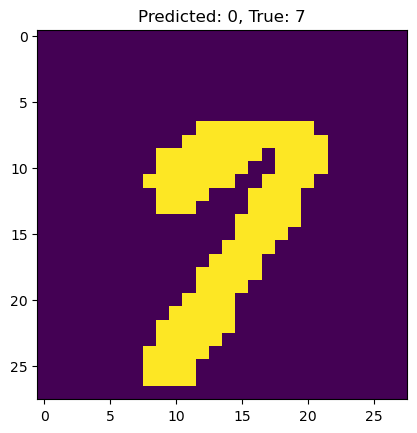

tensor([0.3235, 0.0463, 0.0463, 0.0463, 0.0549, 0.0463, 0.0859, 0.2398, 0.0463,
        0.0646], grad_fn=<SoftmaxBackward0>)
Iteration 11000 | 18.3, loss: 3.038463592529297
Accuracy: 0.23100000619888306
Iteration 12000 | 20.0, loss: 2.45483660697937
Accuracy: 0.24799999594688416
Iteration 13000 | 21.7, loss: 1.7301932573318481
Accuracy: 0.23800000548362732
Iteration 14000 | 23.3, loss: 1.7108469009399414
Accuracy: 0.23100000619888306
Iteration 15000 | 25.0, loss: 1.1864598989486694
Accuracy: 0.24300000071525574
Iteration 16000 | 26.7, loss: 2.2965025901794434
Accuracy: 0.25999999046325684
Iteration 17000 | 28.3, loss: 1.8884471654891968
Accuracy: 0.24799999594688416
Iteration 18000 | 30.0, loss: 2.415513753890991
Accuracy: 0.2770000100135803
Iteration 19000 | 31.7, loss: 1.7935508489608765
Accuracy: 0.26100000739097595
Iteration 20000 | 33.3, loss: 2.838979721069336
Accuracy: 0.2980000078678131


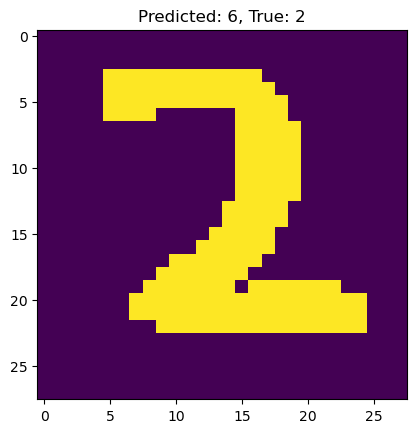

tensor([0.1115, 0.0728, 0.0585, 0.0585, 0.1658, 0.0585, 0.1690, 0.1205, 0.0770,
        0.1079], grad_fn=<SoftmaxBackward0>)
Iteration 21000 | 35.0, loss: 2.133331775665283
Accuracy: 0.26499998569488525
Iteration 22000 | 36.7, loss: 1.7661590576171875
Accuracy: 0.2750000059604645
Iteration 23000 | 38.3, loss: 2.6321616172790527
Accuracy: 0.26600000262260437
Iteration 24000 | 40.0, loss: 2.5165462493896484
Accuracy: 0.2720000147819519
Iteration 25000 | 41.7, loss: 0.9290990829467773
Accuracy: 0.26499998569488525
Iteration 26000 | 43.3, loss: 2.1113386154174805
Accuracy: 0.3149999976158142
Iteration 27000 | 45.0, loss: 2.6236064434051514
Accuracy: 0.2800000011920929
Iteration 28000 | 46.7, loss: 1.4050730466842651
Accuracy: 0.28700000047683716
Iteration 29000 | 48.3, loss: 2.515137195587158
Accuracy: 0.3070000112056732
Iteration 30000 | 50.0, loss: 1.7413544654846191
Accuracy: 0.27300000190734863


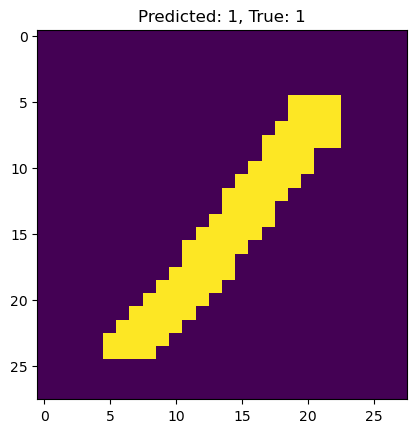

tensor([0.0860, 0.1753, 0.0802, 0.0802, 0.1228, 0.0802, 0.0905, 0.1050, 0.0858,
        0.0939], grad_fn=<SoftmaxBackward0>)
Iteration 31000 | 51.7, loss: 2.5615854263305664
Accuracy: 0.2750000059604645
Iteration 32000 | 53.3, loss: 2.9513490200042725
Accuracy: 0.30000001192092896
Iteration 33000 | 55.0, loss: 1.794564962387085
Accuracy: 0.2849999964237213
Iteration 34000 | 56.7, loss: 1.5959333181381226
Accuracy: 0.3199999928474426
Iteration 35000 | 58.3, loss: 2.1720786094665527
Accuracy: 0.3330000042915344
Iteration 36000 | 60.0, loss: 1.5159333944320679
Accuracy: 0.3199999928474426
Iteration 37000 | 61.7, loss: 2.8788270950317383
Accuracy: 0.30799999833106995
Iteration 38000 | 63.3, loss: 1.2172529697418213
Accuracy: 0.30399999022483826
Iteration 39000 | 65.0, loss: 1.7658758163452148
Accuracy: 0.32499998807907104
Iteration 40000 | 66.7, loss: 2.8080341815948486
Accuracy: 0.30399999022483826


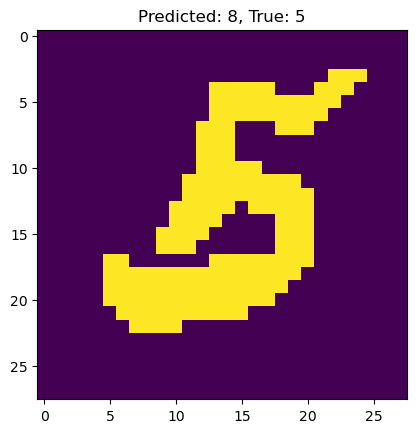

tensor([0.0603, 0.1271, 0.0603, 0.0603, 0.1296, 0.0603, 0.0827, 0.0783, 0.2348,
        0.1063], grad_fn=<SoftmaxBackward0>)
Iteration 41000 | 68.3, loss: 0.9863420128822327
Accuracy: 0.33399999141693115
Iteration 42000 | 70.0, loss: 2.3102731704711914
Accuracy: 0.2939999997615814
Iteration 43000 | 71.7, loss: 1.498513102531433
Accuracy: 0.3269999921321869
Iteration 44000 | 73.3, loss: 1.405006766319275
Accuracy: 0.3319999873638153
Iteration 45000 | 75.0, loss: 2.744774341583252
Accuracy: 0.3149999976158142
Iteration 46000 | 76.7, loss: 1.645391821861267
Accuracy: 0.29899999499320984
Iteration 47000 | 78.3, loss: 4.119399070739746
Accuracy: 0.32199999690055847
Iteration 48000 | 80.0, loss: 3.02775502204895
Accuracy: 0.32499998807907104
Iteration 49000 | 81.7, loss: 2.8446621894836426
Accuracy: 0.32499998807907104
Iteration 50000 | 83.3, loss: 1.309664249420166
Accuracy: 0.28200000524520874


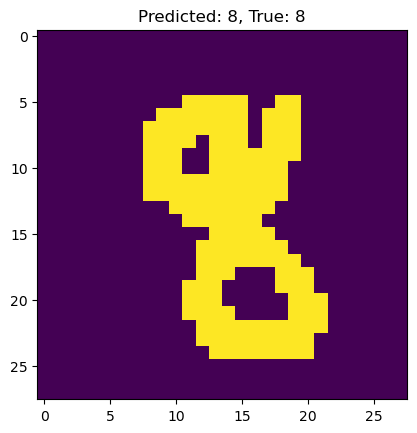

tensor([0.0370, 0.1785, 0.0370, 0.0370, 0.0632, 0.0370, 0.1711, 0.0370, 0.2699,
        0.1321], grad_fn=<SoftmaxBackward0>)
Iteration 51000 | 85.0, loss: 1.4888033866882324
Accuracy: 0.3070000112056732
Iteration 52000 | 86.7, loss: 0.4131530821323395
Accuracy: 0.32499998807907104
Iteration 53000 | 88.3, loss: 3.2907943725585938
Accuracy: 0.33000001311302185
Iteration 54000 | 90.0, loss: 1.0367399454116821
Accuracy: 0.3630000054836273
Iteration 55000 | 91.7, loss: 1.1526442766189575
Accuracy: 0.3400000035762787
Iteration 56000 | 93.3, loss: 2.6304523944854736
Accuracy: 0.3479999899864197
Iteration 57000 | 95.0, loss: 3.058774709701538
Accuracy: 0.3449999988079071
Iteration 58000 | 96.7, loss: 2.6238210201263428
Accuracy: 0.31700000166893005
Iteration 59000 | 98.3, loss: 0.7787327170372009
Accuracy: 0.3540000021457672
Iteration 60000 | 1e+02, loss: 1.4557219743728638
Accuracy: 0.36399999260902405


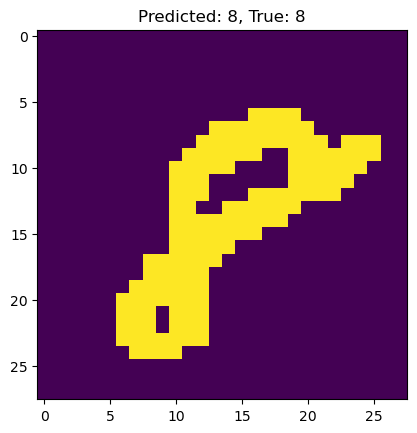

tensor([0.0459, 0.0827, 0.0459, 0.0459, 0.1833, 0.0459, 0.1224, 0.0459, 0.2332,
        0.1490], grad_fn=<SoftmaxBackward0>)


In [180]:
model = CustomGraphNCA()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


accuracy = torch.tensor(0, dtype=torch.float32)
iteration = 0
for img, tg in zip(images, labels):
    image = torch.tensor(img, dtype=torch.float32).unsqueeze(1)
    image_with_dists = torch.cat([image, torch.tensor(dists.reshape(-1, 1), dtype=torch.float32)], dim=1)
    target = torch.tensor(tg, dtype=torch.float32)

    optimizer.zero_grad()
    output = model(image_with_dists, edge_index, edge_weights)

    # output in range (-inf, 0) make into logits
    

    loss_val = loss(output.view(1, -1), target.view(1).long())

    # print(output.shape)
    loss_val.backward()
    optimizer.step()
    iteration += 1

    props = F.softmax(output, dim=0)

    accuracy += (props.argmax() == tg).float()
    if iteration % 1000 == 0:
        print(f'Iteration {iteration} | {iteration/len(images)*100:.3}, loss: {loss_val.item()}')
        print(f'Accuracy: {accuracy/1000}')
        accuracy = torch.tensor(0, dtype=torch.float32)

    if iteration % 10000 == 0:
        plt.imshow(img.reshape(28,28))
        plt.title('Predicted: %d, True: %d' % (props.argmax(), tg))
        plt.show()
        print(props)

